In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import tensorflow as tf
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
import glob
uav_path = '../../data/22050/loaded/*.*'
loaded_path = '../../data/22050/unloaded/*.*'
none_path = '../../data/22050/none/*.*'

uav_files = glob.glob(uav_path)
loaded_files = glob.glob(loaded_path)
none_files = glob.glob(none_path)

In [3]:
print(len(uav_files),'개\t', uav_files[0])
print(len(uav_files),'개\t', loaded_files[0])
print(len(none_files), '개\t',none_files[0])

10 개	 ../../data/22050/loaded\LGgram_P2_loaded bck and forth.wav
10 개	 ../../data/22050/unloaded\LGgram_P2_unloaded back forth.wav
25 개	 ../../data/22050/none\background_06_02_01.WAV


# Load Data

The reason of why SR is 44100 is that the sample rate of above files is 44.1kbps

a wav file sample has 884736. if sample is divided by sample rate, the value is time
the time is fixed by 20.06

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
uav_raw = load(uav_files)
loaded_raw = load(loaded_files)
none_raw = load(none_files)

(14077547,)
(23781589,)
(10960896,)


# Feature extraction 
## steps
#### 1. Resampling 
#### 2. *VAD*( Voice Activity Detection)
#### 3. Maybe padding with 0 to make signals be equal length
#### 4. Log spectrogram (or *MFCC*, or *PLP*)
#### 5. Features normalization with *mean* and *std*
#### 6. Stacking of a given number of frames to get temporal information



## 1. Resampling

if you see the graph, there are few at high frequency. this is mean that data is big but it's no useless. so To small the data, do Resampling. In general, use 0~8000Hz 

## 2. VAD

Sometimes, Files have silence. It is not necessary. So, We need to find sound of Drone except silence.

But, Not yet implemented

## 3. padding with 0 to make signals be equal length

If we have a lot of sound files, we need to pad some datas. But These files's time is longger than 1 second. So It dosn't need to pad

## 4. Log spectrogram (or MFCC, or PLP)

The upper picture is resampled data. 
The lower picture is original data.

In MFCC Feature, There is no big difference. 

In [6]:
from scipy.stats import skew
#returns mfcc features with mean and standard deviation along time
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc* n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        #print(mfcc_slice.shape)
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0]* mfcc_slice.shape[1]))
        #print(mfcc_slice.shape)
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
def mfcc(raw, chunk_size=8192, sr=22050, n_mfcc=13):
    mfcc = np.empty((13, 0))
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        mfcc = np.hstack((mfcc, mfcc_slice))
    return mfcc

In [7]:
'''
mfcc_uav, y_uav = mfcc4(uav_raw, 1)
print(mfcc_uav.shape, y_uav.shape)
mfcc_none, y_none = mfcc4(none_raw, 0)
print(mfcc_none.shape, y_none.shape)
'''
mfcc_uav = mfcc(uav_raw)
mfcc_loaded = mfcc(loaded_raw)
mfcc_none = mfcc(none_raw)


In [8]:
# or should we give one label to one chunk?
y_uav = np.ones(mfcc_uav.shape[1], dtype=int)*2
y_loaded = np.ones(mfcc_loaded.shape[1], dtype=int)
y_none =np.zeros(mfcc_none.shape[1], dtype=int)

print(y_uav.shape, y_uav[0])
print(y_loaded.shape, y_loaded[0])
print(y_none.shape, y_none[0])

X = np.hstack((mfcc_uav, mfcc_loaded))
X = np.hstack((X, mfcc_none)).T

y = np.hstack((y_uav, y_loaded))
y = np.hstack((y, y_none))
print(X.shape, y.shape)

(29214,) 2
(49352,) 1
(22746,) 0
(101312, 13) (101312,)


In [9]:
n_labels = y.shape[0]
n_unique_labels = 3
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)
print(y_encoded[0], y_encoded[40000],y_encoded[100000])

(101312, 3)
[0. 0. 1.] [0. 1. 0.] [1. 0. 0.]


In [10]:
'''
mfcc_uav_list = mfcc_uav.tolist()
mfcc_uav_list = mfcc_uav_list
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(mfcc_uav_list), len(mfcc_uav_list)),mfcc_uav_list)
'''

'\nmfcc_uav_list = mfcc_uav.tolist()\nmfcc_uav_list = mfcc_uav_list\nfig = plt.figure(figsize=(15,9))\nax = fig.add_subplot(1,1,1)\nax.plot(np.linspace(0,len(mfcc_uav_list), len(mfcc_uav_list)),mfcc_uav_list)\n'

## 5. Features normalization with *mean* and *std*

## 6. Stacking of a given number of frames to get temporal information

In [11]:
'''
X = np.concatenate((mfcc_uav, mfcc_none), axis=0)
Y = np.hstack((y_uav, y_none))
print(X.shape, Y.shape)
X = np.reshape(X,(X.shape[0],-1))# 선범 

n_labels = Y.shape[0]
n_unique_labels = 2
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), Y] = 1
print(y_encoded.shape)
'''

'\nX = np.concatenate((mfcc_uav, mfcc_none), axis=0)\nY = np.hstack((y_uav, y_none))\nprint(X.shape, Y.shape)\nX = np.reshape(X,(X.shape[0],-1))# 선범 \n\nn_labels = Y.shape[0]\nn_unique_labels = 2\ny_encoded = np.zeros((n_labels, n_unique_labels))\ny_encoded[np.arange(n_labels), Y] = 1\nprint(y_encoded.shape)\n'

In [12]:
dataX = X
dataY = y_encoded
print(y_encoded)
print(dataX.shape, dataY.shape)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(101312, 13) (101312, 3)


In [13]:
seq_length = 16 #layer
X_hot_list= []
#Y_hot = dataY[seq_length-1:].reshape(len(dataY[seq_length-1:]), 1)
Y_hot_tmp = dataY[seq_length-1:]

for i in range(0, dataX.shape[0] - seq_length+1):
    _x = dataX[i:i + seq_length]
    #if i<10:
        #print(_x, "->", Y_hot_tmp[i])
    X_hot_list.append(_x)

X_hot = np.array(X_hot_list[:])
Y_hot= Y_hot_tmp.reshape((len(Y_hot_tmp),n_unique_labels))
print(X_hot.shape, Y_hot.shape)


(101297, 16, 13) (101297, 3)


In [14]:
class Data:
    def __init__(self,X,Y,BatchSize):
        self.X = X
        self.Y = Y
        self.len = len(Y)
        self.bs = BatchSize
        self.bs_i = 0
    def getBatchData(self):
        s = self.bs_i
        e = self.bs_i + self.bs
        if e> self.len:
            e -= self.len
            result =  np.vstack((self.X[s:],self.X[:e])), np.vstack((self.Y[s:],self.Y[:e]))
        else:
            result =  self.X[s:e], self.Y[s:e]
            
        self.bs_i = e
        return result
dataX = [1,2,3,4,5,6,7,8]
dataY = [11,12,13,14,15,16,17,18]
D = Data(dataX, dataY,3)
x, y = D.getBatchData()
print(x,y)
x, y = D.getBatchData()
print(x,y)

[1, 2, 3] [11, 12, 13]
[4, 5, 6] [14, 15, 16]


In [15]:
'''
X_dim = 256
X_train = np.zeros(shape=[0,9,X_dim],dtype=float)
y_train = np.zeros(shape=[0,n_unique_labels],dtype=float)
X_test = np.zeros(shape=[0,9,X_dim],dtype=float)
y_test = np.zeros(shape=[0,n_unique_labels],dtype=float)

split_rate = 0.9
none_len = len(y_none)
uav_len = len(X_hot) - none_len
print('uav_len, none_len', uav_len,none_len)

train_size = int(uav_len * split_rate)
test_size = uav_len - train_size
base = 0
print('train_uav, test_uav',train_size,test_size)

X_tr, X_te = np.array(X_hot[base:base+train_size]),np.array(X_hot[base+train_size:base+train_size+test_size])
y_tr, y_te = np.array(Y_hot[base:base+train_size]),np.array(Y_hot[base+train_size:base+train_size+test_size])
print(X_tr.shape,X_te.shape)
print(y_tr.shape,y_te.shape)

X_train = np.vstack((X_train,X_tr))
X_test= np.vstack((X_test,X_te))
y_train= np.vstack((y_train,y_tr))
y_test= np.vstack((y_test,y_te))

train_size = int(none_len * split_rate)
test_size = none_len - train_size
base = uav_len
print('none',train_size,test_size)

X_tr, X_te = np.array(X_hot[base:base+train_size]),np.array(X_hot[base+train_size:base+train_size+none_len])
y_tr, y_te = np.array(Y_hot[base:base+train_size]),np.array(Y_hot[base+train_size:base+train_size+none_len])
print(X_tr.shape,X_te.shape)
print(y_tr.shape,y_te.shape)

print(base+none_len)
X_train = np.vstack((X_train,X_tr))
X_test= np.vstack((X_test,X_te))
y_train= np.vstack((y_train,y_tr))
y_test= np.vstack((y_test,y_te))
'''

"\nX_dim = 256\nX_train = np.zeros(shape=[0,9,X_dim],dtype=float)\ny_train = np.zeros(shape=[0,n_unique_labels],dtype=float)\nX_test = np.zeros(shape=[0,9,X_dim],dtype=float)\ny_test = np.zeros(shape=[0,n_unique_labels],dtype=float)\n\nsplit_rate = 0.9\nnone_len = len(y_none)\nuav_len = len(X_hot) - none_len\nprint('uav_len, none_len', uav_len,none_len)\n\ntrain_size = int(uav_len * split_rate)\ntest_size = uav_len - train_size\nbase = 0\nprint('train_uav, test_uav',train_size,test_size)\n\nX_tr, X_te = np.array(X_hot[base:base+train_size]),np.array(X_hot[base+train_size:base+train_size+test_size])\ny_tr, y_te = np.array(Y_hot[base:base+train_size]),np.array(Y_hot[base+train_size:base+train_size+test_size])\nprint(X_tr.shape,X_te.shape)\nprint(y_tr.shape,y_te.shape)\n\nX_train = np.vstack((X_train,X_tr))\nX_test= np.vstack((X_test,X_te))\ny_train= np.vstack((y_train,y_tr))\ny_test= np.vstack((y_test,y_te))\n\ntrain_size = int(none_len * split_rate)\ntest_size = none_len - train_size\nb

In [16]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_hot, Y_hot, test_size=0.2, random_state=42)

In [17]:
batch_size = 1024
traindata = Data(X_train,y_train,batch_size)
testdata = Data(X_test,y_test,batch_size)

In [18]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(81037, 16, 13) (20260, 16, 13)
(81037, 3) (20260, 3)


In [19]:
'''
np.save('../data/Xy/X_train2', X_train)
np.save('../data/Xy/X_test2', X_test)
np.save('../data/Xy/y_train2', y_train)
np.save('../data/Xy/y_test2', y_test)
'''

"\nnp.save('../data/Xy/X_train2', X_train)\nnp.save('../data/Xy/X_test2', X_test)\nnp.save('../data/Xy/y_train2', y_train)\nnp.save('../data/Xy/y_test2', y_test)\n"

In [20]:
'''
X_train = np.load('../data/Xy/X_train2.npy')
X_test = np.load('../data/Xy/X_test2.npy')
y_train = np.load('../data/Xy/y_train2.npy')
y_test = np.load('../data/Xy/y_test2.npy')
'''

"\nX_train = np.load('../data/Xy/X_train2.npy')\nX_test = np.load('../data/Xy/X_test2.npy')\ny_train = np.load('../data/Xy/y_train2.npy')\ny_test = np.load('../data/Xy/y_test2.npy')\n"

# Tensorflow RNN

## Train 

In [21]:
batch_size = batch_size
num_classes = 13            #분류할 사전의 크기 

learning_rate = 0.01
sequence_length = seq_length #9         

output_dim = n_unique_labels
layers = 3

In [22]:
X = tf.placeholder(tf.float32, [None, sequence_length,num_classes], name="X")
Y = tf.placeholder(tf.float32, [None, output_dim], name="Y")

cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_classes, state_is_tuple=True)
cell = tf.contrib.rnn.MultiRNNCell([cell]*layers, state_is_tuple= True)

initial_state = cell.zero_state(batch_size, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(cell, X,initial_state=initial_state,dtype=tf.float32)

dense1 = tf.contrib.layers.fully_connected(outputs[:,-1], output_dim, activation_fn=None)
dense2 = tf.layers.dense(inputs=dense1, units=output_dim, activation=tf.nn.relu)


In [23]:

Y_pred= tf.layers.dense(inputs=dense2, units=output_dim)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_pred, labels=Y))
lr = tf.placeholder(tf.float32,shape=(), name='learning_rate')
train = tf.train.AdamOptimizer(lr).minimize(cost)


In [24]:
traindata.X[0]

array([[-22.0271102 ,  44.45796608, -16.81921293,  28.58088165,
        -20.21966691,  17.78120399,  -5.26962715,  15.44042813,
          3.50293016,  12.11053418,   7.38301421,   1.43603353,
          5.23186589],
       [-28.8449711 ,  43.59542704, -14.87262236,  20.83758294,
        -21.88811659,  17.84122881,  -5.88527807,  12.87017004,
          5.3933842 ,  12.70081834,   2.15844202,   1.58403938,
          7.7837879 ],
       [-28.3032851 ,  44.79240549, -14.96570827,  22.73259997,
        -21.59513053,  14.5566326 ,  -6.47910848,  15.18947468,
          3.62236637,  11.43807572,   2.30163804,  -0.54407771,
          4.21434993],
       [-28.95163981,  46.27454382, -15.38487285,  26.22065461,
        -22.13071886,   8.7152196 ,  -9.61704134,  11.44961277,
          1.63580257,  13.93560792,   2.93375169,  -3.52067628,
         -2.75554843],
       [-29.37341523,  48.07906995, -18.34130497,  26.59050163,
        -20.83925559,  11.3864304 ,  -8.60146463,  11.19378418,
          3.

In [25]:
print(traindata.Y)

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [26]:
x, y = traindata.getBatchData()
print(y)

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [27]:
init = tf.global_variables_initializer()
cost_history = np.empty(shape=[1],dtype=float)
step_loss = 999999.0
model_path = '../../models/RNN/my_RNN_model_S9_10'
saver = tf.train.Saver()
training_epochs = 500
# Training step

sess = tf.InteractiveSession()
sess.run(init)
for learning_rate in [0.02,0.01]:
    test_acc = []
    feed = {lr:learning_rate}
    for i in range(training_epochs):
        x,y = traindata.getBatchData()
        feed[X], feed[Y] = x, y
        step_loss_prev = step_loss
        _, step_loss = sess.run([train, cost], feed_dict=feed)
        cost_history = np.append(cost_history,step_loss)
        
        print("[step: {}] loss: {}".format(i, step_loss))
        #batch_acc, test_state = sess.run([loss, _states], feed_dict=feed)
    print("Test accuracy: {:.3f}".format(1.0-np.mean(cost_history)))

saver.save(sess, model_path)
sess.close()

[step: 0] loss: 1.1106698513031006
[step: 1] loss: 1.091935396194458
[step: 2] loss: 1.0793190002441406
[step: 3] loss: 1.0684373378753662
[step: 4] loss: 1.0580294132232666
[step: 5] loss: 1.044013500213623
[step: 6] loss: 1.0370820760726929
[step: 7] loss: 1.0343177318572998
[step: 8] loss: 1.0405983924865723
[step: 9] loss: 1.0432360172271729
[step: 10] loss: 1.0144588947296143
[step: 11] loss: 1.0256236791610718
[step: 12] loss: 1.0097323656082153
[step: 13] loss: 0.9795637726783752
[step: 14] loss: 0.9933551549911499
[step: 15] loss: 0.9402954578399658
[step: 16] loss: 0.9755253791809082
[step: 17] loss: 0.9795761108398438
[step: 18] loss: 0.9172914028167725
[step: 19] loss: 0.9505681991577148
[step: 20] loss: 0.9257932305335999
[step: 21] loss: 0.9441235065460205
[step: 22] loss: 0.8700234889984131
[step: 23] loss: 0.8469570875167847
[step: 24] loss: 0.862381637096405
[step: 25] loss: 0.881547212600708
[step: 26] loss: 0.8764456510543823
[step: 27] loss: 0.8498073220252991
[step:

[step: 225] loss: 0.20147070288658142
[step: 226] loss: 0.1778988242149353
[step: 227] loss: 0.1839306652545929
[step: 228] loss: 0.18369171023368835
[step: 229] loss: 0.14596998691558838
[step: 230] loss: 0.15600723028182983
[step: 231] loss: 0.18612441420555115
[step: 232] loss: 0.18840959668159485
[step: 233] loss: 0.1482822597026825
[step: 234] loss: 0.17613324522972107
[step: 235] loss: 0.1542210876941681
[step: 236] loss: 0.1674022674560547
[step: 237] loss: 0.17261892557144165
[step: 238] loss: 0.15582507848739624
[step: 239] loss: 0.1514674425125122
[step: 240] loss: 0.1436653584241867
[step: 241] loss: 0.14705637097358704
[step: 242] loss: 0.15277187526226044
[step: 243] loss: 0.17603152990341187
[step: 244] loss: 0.1973428726196289
[step: 245] loss: 0.21344521641731262
[step: 246] loss: 0.1660567820072174
[step: 247] loss: 0.15785732865333557
[step: 248] loss: 0.1402185708284378
[step: 249] loss: 0.17570924758911133
[step: 250] loss: 0.15328462421894073
[step: 251] loss: 0.14

[step: 443] loss: 0.08363862335681915
[step: 444] loss: 0.09026548266410828
[step: 445] loss: 0.09487493336200714
[step: 446] loss: 0.11362206935882568
[step: 447] loss: 0.07685619592666626
[step: 448] loss: 0.08694148063659668
[step: 449] loss: 0.08828479051589966
[step: 450] loss: 0.12654830515384674
[step: 451] loss: 0.08394722640514374
[step: 452] loss: 0.09362143278121948
[step: 453] loss: 0.0816316232085228
[step: 454] loss: 0.07405291497707367
[step: 455] loss: 0.09716018289327621
[step: 456] loss: 0.09729664772748947
[step: 457] loss: 0.08638593554496765
[step: 458] loss: 0.08077973127365112
[step: 459] loss: 0.09721516817808151
[step: 460] loss: 0.09908752143383026
[step: 461] loss: 0.09547989070415497
[step: 462] loss: 0.09384915232658386
[step: 463] loss: 0.08489514887332916
[step: 464] loss: 0.10253145545721054
[step: 465] loss: 0.0808345302939415
[step: 466] loss: 0.09908749908208847
[step: 467] loss: 0.08394177258014679
[step: 468] loss: 0.0939890593290329
[step: 469] los

[step: 162] loss: 0.08457586169242859
[step: 163] loss: 0.09090946614742279
[step: 164] loss: 0.07629240304231644
[step: 165] loss: 0.0921359583735466
[step: 166] loss: 0.07702124118804932
[step: 167] loss: 0.05549941584467888
[step: 168] loss: 0.09109747409820557
[step: 169] loss: 0.05176059156656265
[step: 170] loss: 0.08818794786930084
[step: 171] loss: 0.08006605505943298
[step: 172] loss: 0.09875117242336273
[step: 173] loss: 0.07620944082736969
[step: 174] loss: 0.08063238114118576
[step: 175] loss: 0.06361838430166245
[step: 176] loss: 0.05140473693609238
[step: 177] loss: 0.05960940942168236
[step: 178] loss: 0.07221539318561554
[step: 179] loss: 0.07814033329486847
[step: 180] loss: 0.07910725474357605
[step: 181] loss: 0.06933646649122238
[step: 182] loss: 0.06007182225584984
[step: 183] loss: 0.07715068757534027
[step: 184] loss: 0.0808628648519516
[step: 185] loss: 0.04509631544351578
[step: 186] loss: 0.08483563363552094
[step: 187] loss: 0.07801759243011475
[step: 188] lo

[step: 379] loss: 0.07309561967849731
[step: 380] loss: 0.07278093695640564
[step: 381] loss: 0.06493207812309265
[step: 382] loss: 0.07150764763355255
[step: 383] loss: 0.056909140199422836
[step: 384] loss: 0.06956321001052856
[step: 385] loss: 0.05508992075920105
[step: 386] loss: 0.06636875122785568
[step: 387] loss: 0.07139710336923599
[step: 388] loss: 0.06614593416452408
[step: 389] loss: 0.05413707718253136
[step: 390] loss: 0.07247669994831085
[step: 391] loss: 0.05914561077952385
[step: 392] loss: 0.04753538593649864
[step: 393] loss: 0.05818605050444603
[step: 394] loss: 0.08906020224094391
[step: 395] loss: 0.0781654566526413
[step: 396] loss: 0.07308288663625717
[step: 397] loss: 0.05973582714796066
[step: 398] loss: 0.06191243603825569
[step: 399] loss: 0.07747600972652435
[step: 400] loss: 0.07615320384502411
[step: 401] loss: 0.0722237378358841
[step: 402] loss: 0.08021442592144012
[step: 403] loss: 0.06268039345741272
[step: 404] loss: 0.05969785153865814
[step: 405] l

In [35]:
sess = tf.InteractiveSession()
saver.restore(sess, model_path)
x , y = testdata.getBatchData()
y_pred = sess.run(tf.argmax(Y_pred,1),feed_dict={X: x})
y_true = sess.run(tf.argmax(y,1))
print(y_pred.shape, y_true.shape)

INFO:tensorflow:Restoring parameters from ../../models/RNN/my_RNN_model_S9_10
(1024,) (1024,)


In [36]:
sess.close()

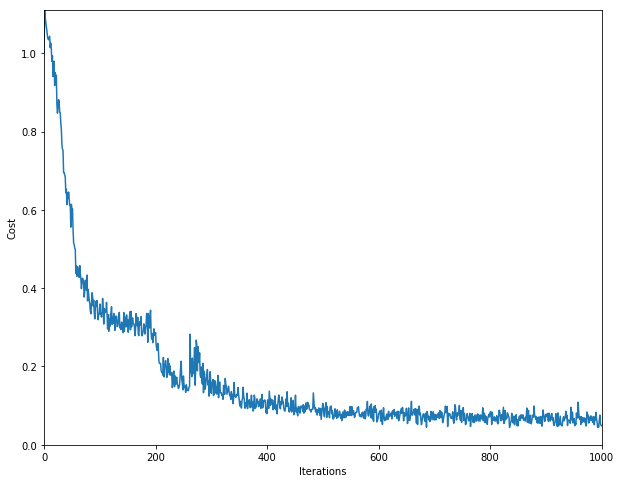

F-Score: 0.976
Accuracy:  0.9755859375
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       225
          1       0.97      0.99      0.98       515
          2       0.97      0.94      0.96       284

avg / total       0.98      0.98      0.98      1024

[[222   0   3]
 [  1 510   4]
 [  3  14 267]]


In [37]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations") 
plt.axis([0,len(cost_history),0,np.max(cost_history)])
plt.show()


p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
print("Accuracy: ", accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

In [31]:
'''
model_path_f = '../models/RNN/'
filename = 'my_RNN_model_S9_40.meta'


sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
loader = tf.train.import_meta_graph(model_path_f+filename)
loader.restore(sess, tf.train.latest_checkpoint(model_path_f))

SR = 22050
####
justone = True

while(justone):
    justone = False
    #print("start to record the audio.")
    
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    #print("Recording finished.")
    stream.stop_stream()
    stream.close()

    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    ####
    filename1 = '../data/phantom/JUNE_01_PHANTOMS/wavs/22050/WSU_P2_LOADED_BACK_AND_FORTH.wav'
    filename2 = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/canopy_heavy_wind.wav'
    
    sample, sample_rate = librosa.load(filename1,SR)
    print(sample.shape)
    
    
    freqs, times, spectrogram = log_specgram(sample, sample_rate)    
    #showFreqTime([[sample, filename1, SR]])  

    spectrogram = (spectrogram - mean) / std
    
    dataX = spectrogram
    #print(dataX.shape)
    #print('delta shape:',dataX.shape)

    X_hot_list= []
    #print(dataX.shape[0] - seq_length+1)
    for i in range(0, dataX.shape[0] - seq_length+1):
        _x = dataX[i:i + seq_length]
        X_hot_list.append(_x)
    X_hot = np.array(X_hot_list[:])
    #print(X_hot[0])
    #print('\n\n\n')
    y_pred = sess.run(Y_pred,feed_dict={X: X_hot})
    #y_pred[y_pred<0.5] = 0
    #y_pred[y_pred>=0.5] = 1
    print(y_pred[20:30] )
    y_true = np.ones(shape=[y_pred.shape[0]])
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>=0.5] = 1
    
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print("F-Score:", round(f,3))
    print("Accuracy: ", accuracy_score(y_true, y_pred))

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

    
    if y_pred[0] == 1:
        print('The sound is Drone')
    else :
        print('THe sound isn\'t Drone')
    

sess.close()
'''

'\nmodel_path_f = \'../models/RNN/\'\nfilename = \'my_RNN_model_S9_40.meta\'\n\n\nsess = tf.InteractiveSession()\nsess.run(tf.global_variables_initializer())\nloader = tf.train.import_meta_graph(model_path_f+filename)\nloader.restore(sess, tf.train.latest_checkpoint(model_path_f))\n\nSR = 22050\n####\njustone = True\n\nwhile(justone):\n    justone = False\n    #print("start to record the audio.")\n    \n    frames = []\n    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):\n        data = stream.read(CHUNK)\n        frames.append(data)\n    #print("Recording finished.")\n    stream.stop_stream()\n    stream.close()\n\n    p.terminate()\n\n    wf = wave.open(WAVE_OUTPUT_FILENAME, \'wb\')\n    wf.setnchannels(CHANNELS)\n    wf.setsampwidth(p.get_sample_size(FORMAT))\n    wf.setframerate(RATE)\n    wf.writeframes(b\'\'.join(frames))\n    wf.close()\n    \n    ####\n    filename1 = \'../data/phantom/JUNE_01_PHANTOMS/wavs/22050/WSU_P2_LOADED_BACK_AND_FORTH.wav\'\n    filename2 = \'../d